# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: Чаусов Дмитрий Николаевич

Группа: MADE-DS-11

In [242]:
import pandas as pd
import geopandas as gpd
import folium
import random
import overpy
import numpy as np
import time
import pyproj
import pycountry

from folium.features import GeoJson, GeoJsonTooltip, GeoJsonPopup
from shapely import geometry
from shapely.geometry import Point, Polygon, LineString, mapping, shape, MultiPolygon
from shapely.ops import cascaded_union
from rtree import index
from rtree.index import Rtree
from openrouteservice import client
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from OSMPythonTools.nominatim import Nominatim
from tqdm import tqdm
from countryinfo import CountryInfo


## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

с помощью https://geojson-maps.ash.ms/ взял полигон Афганистана

In [2]:
df = gpd.read_file("afgan.json")

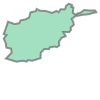

In [3]:
afg = df['geometry']
poly_afg = afg[0]
poly_afg

Полигон изображен верно. Но почему то координаты широты и долготы в нем переставлены местами

In [4]:
# координаты полигона, которые я достал из json'a и поменял местами
afg_coords = [[35.650072333309225, 61.21081709172574],[35.270663967422294, 62.230651483005886],
 [35.40404083916762, 62.9846623065766],[35.857165635718914, 63.19353844590035],[36.0079574651466, 63.9828959491587],
 [36.31207326918427, 64.5464791197339],[37.111817735333304, 64.7461051776774],
 [37.30521678318564, 65.58894778835784],[37.66116404881207, 65.74563073106681],
 [37.39379018813392, 66.21738488145932],[37.36278432875879, 66.51860680528867],
 [37.35614390720929, 67.07578209825962],[37.14499400486468, 67.82999962755952],
 [37.0231151393043, 68.13556237170138],[37.344335842430596, 68.85944583524594],
 [37.15114350030743, 69.19627282092438],[37.60899669041341, 69.51878543485796],
 [37.58822276463209, 70.11657840361033],[37.735164699854025, 70.27057417184014],
 [38.13839590102752, 70.3763041523093],[38.486281643216415, 70.80682050973289],
 [38.258905341132156, 71.34813113799026],[37.95326508234188, 71.23940392444817],
 [37.905774441065645, 71.54191775908478],[37.06564484308051, 71.44869347523024],
 [36.73817129164692, 71.8446382994506],[36.948287665345674, 72.1930408059624],
 [37.047558091778356, 72.63688968291729],[37.495256862939, 73.26005577992501],
 [37.4215662704908, 73.9486959166465],[37.419990139305895, 74.98000247589542],
 [37.13303091078912, 75.15802778514092],[37.02084137628346, 74.57589277537298],
 [36.83617564548845, 74.06755171091783],[36.72000702569632, 72.92002485544447],
 [36.50994232842986, 71.84629194528392],[36.074387518857804, 71.26234826038575],
 [35.650563259416, 71.49876793812109],[35.153203436822864, 71.6130762063507],
 [34.733125718722235, 71.11501875192162],[34.34891144463215, 71.15677330921346],
 [33.98885590263851, 70.8818030129884],[34.02012014417511, 69.9305432473596],
 [33.35853261975839, 70.3235941913716],[33.105498969041236, 69.68714725126485],
 [32.5019440780883, 69.26252200712256],[31.90141225842444, 69.31776411324255],
 [31.620189113892064, 68.92667687365767],[31.713310044882018, 68.55693200060932],
 [31.58293040620963, 67.79268924344478],[31.30315420178142, 67.68339358914747],
 [31.304911200479353, 66.93889122911847],[30.73889923758645, 66.38145755398602],
 [29.887943427036177, 66.34647260932442],[29.472180691031905, 65.0468620136161],
 [29.560030625928093, 64.35041873561852],[29.340819200145972, 64.14800215033125],
 [29.468330796826162, 63.55026085801117],[29.31857249604431, 62.54985680527278],
 [29.829238999952604, 60.874248488208785],[30.735850328081234, 61.781221551363444],
 [31.37950613049267, 61.699314406180825],[31.548074652628753, 60.94194461451113],
 [32.18291962333443, 60.863654819588966],[32.98126882581157, 60.536077915290775],
 [33.52883230237625, 60.963700392506006],[33.676446031218006, 60.52842980331158],
 [34.40410187431986, 60.80319339380745],[35.650072333309225, 61.21081709172574]]

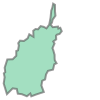

In [5]:
poly = Polygon(afg_coords) 
poly

выглядит перевернутым, но почему то так работает корректно

добавим на карту folium

In [7]:
afg_map = folium.Map(location=[33.9340384, 67.7034313], zoom_start=6)

folium.GeoJson(df).add_to(afg_map)

afg_map

2й способ

In [9]:
afg_map2 = folium.Map(location=[33.9340384, 67.7034313], zoom_start=6)


folium.Polygon(
    locations=afg_coords,
    color='blue',
    weight=6,
    fill_color='red',
    fill_opacity=0.5,
    fill=True,
    popup='Afganistan',
    tooltip='Click me!',
).add_to(afg_map2)


afg_map2

функции для нахождения рандомной точки и добавления точки в фолиум

In [10]:
def random_point(LON_min, LON_max, LAT_min, LAT_max):

    point=(random.uniform(LON_min, LON_max),random.uniform(LAT_min, LAT_max))

    return(point)

def draw_points(map_object, list_of_points, layer_name, line_color, fill_color, text):

    fg = folium.FeatureGroup(name=layer_name)

    for point in list_of_points:
        fg.add_child(folium.CircleMarker(point, radius=1, color=line_color, fill_color=fill_color,
                                         popup=(folium.Popup(text))))

    map_object.add_child(fg)

In [82]:
# изначальные ограничения поиска
min_lat = -180 
max_lat = 180
min_lon = -90
max_lon = 90

In [83]:
our_point = random_point(LON_min=min_lon, LON_max=max_lon, LAT_min=min_lat, LAT_max=max_lat)
our_point

(15.266290756720437, -74.31581123774035)

In [84]:
points_geo = [] # массив точек, которые будем добавлять на карту
next_point = Point(our_point)
print(next_point)
points_geo.append(our_point)

POINT (15.26629075672044 -74.31581123774035)


два метода: нахождения точки в полигоне, и принадлежности точки полигону

In [77]:
print(poly_afg.contains(next_point))
print(poly.contains(next_point))

False
False


In [78]:
print(next_point.within(poly))
print(next_point.within(poly_afg))

False
False


In [79]:
print(poly.centroid)
print(poly_afg.centroid)

POINT (33.85639928169076 66.08669022192835)
POINT (66.08669022192835 33.85639928169076)


In [85]:
flag = True
while flag:
    if our_point[0] >= poly.centroid.x and our_point[1] >= poly.centroid.y:
        max_lat //= 2
        max_lon //= 2
    elif our_point[0] >= poly.centroid.x and our_point[1] < poly.centroid.y:
        min_lat //= 2
        max_lon //= 2
    elif our_point[0] < poly.centroid.x and our_point[1] >= poly.centroid.y:
        max_lat //= 2
        min_lon //= 2
    else:
        min_lat //= 2
        min_lon //= 2
    our_point = random_point(LON_min=min_lon, LON_max=max_lon, LAT_min=min_lat, LAT_max=max_lat)
    next_point = Point(our_point)
    points_geo.append(our_point)
    if poly.contains(next_point) == True:
        flag = False

In [86]:
print(min_lat)
print(max_lat)
print(min_lon)
print(max_lon)
print(points_geo[-1])

-12
90
-6
45
(29.815192348194714, 62.738134054484405)


In [87]:
draw_points(afg_map2, points_geo, layer_name='Example random',
           line_color='royalblue', fill_color='royalblue', text='Example random')

afg_map2

Просто рандомные точки, для интереса

In [88]:
min_lat, max_lat, min_lon, max_lon = -180, 180, -90, 90
our_point2 = random_point(LON_min=min_lon, LON_max=max_lon, LAT_min=min_lat, LAT_max=max_lat)
points_geo2 = []
next_point2 = Point(our_point2)
points_geo2.append(our_point2)
flag = True
while flag:
    our_point2 = random_point(LON_min=min_lon, LON_max=max_lon, LAT_min=min_lat, LAT_max=max_lat)
    next_point2 = Point(our_point2)
    points_geo2.append(our_point2)
    if poly.contains(next_point2) == True:
        flag = False

In [89]:
draw_points(afg_map, points_geo2, layer_name='Example random2',
           line_color='royalblue', fill_color='royalblue', text='Example random2')

afg_map

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

### 1. 1 найдем объекты жилой недвижимости в соседних странах

In [90]:
country = ["IR", "TM", "UZ", "TJ", "PK"] # коды стран

соседи: 
- Иран(столица Тегеран) - IR
- Туркменистан(столица Ашхабат) - TM
- Узбекистан(столица Ташкент) - UZ
- Таджикистан(столица Душанбе 27547977) - TJ
- Пакистан(столица Исламабад) - PK


In [92]:
api = overpy.Overpass()

In [99]:
tags = ["residential", 'house', 'apartments', 
        'detached', 'static_caravan', 'semidetached_house', 
        'bungalow', 'vila'] #  тэги жилых домов, которые почему, то нельзя кормально внести в апи

In [127]:
max_count_houses = {}

Возможно в OSM для стран ближнего востока некорректно введены тэги для жилых домов при привязки их к areaID. Метод  ниже корректно работает для стран Европы и Америки. Да и по самим тегам ничего не находит

#### 1.1.1. Пакистан

In [93]:
pakistan = api.query("""
area["ISO3166-1"='PK'](area);
(node[building=yes](area);
way[building=yes](area);
rel[building=yes](area);
);
out;
""")

In [94]:
len(pakistan.nodes), len(pakistan.ways), len(pakistan.relations)

(1676, 0, 0)

In [128]:
max_count_houses['pakistan'] = len(pakistan.nodes)

#### 1.1.2. Иран

In [108]:
iran = api.query("""
area["ISO3166-1"='IR'](area);
(node[building=yes](area);
 way[building=yes](area);
 rel[building=yes](area);
);
out;
""")

In [109]:
len(iran.nodes), len(iran.ways), len(iran.relations)

(538, 0, 0)

In [129]:
max_count_houses['iran'] = len(iran.nodes)

#### 1.1.3. Таджикистан

In [106]:
tj = api.query("""
area["ISO3166-1"="TJ"](area);
(node[building=yes](area);
 way[building=yes](area);
 rel[building=yes](area);
);
out;
""")

In [107]:
len(tj.nodes), len(tj.ways), len(tj.relations)

(57, 0, 0)

In [130]:
max_count_houses['tj'] = len(tj.nodes)

#### 1.1.4. Туркменистан

In [104]:
tm = api.query("""
area["ISO3166-1"="TM"](area);
(node[building=yes](area);
 way[building=yes](area);
 rel[building=yes](area);
);
out;
""")

In [105]:
len(tm.nodes), len(tm.ways), len(tm.relations)

(10, 0, 0)

In [131]:
max_count_houses['tm'] = len(tm.nodes)

#### 1.1.5. Узбекистан

In [102]:
uz = api.query("""
area["ISO3166-1"="UZ"](area);
(node[building=yes](area);
 way[building=yes](area);
 rel[building=yes](area);
);
out;
""")

In [103]:
len(uz.nodes), len(uz.ways), len(uz.relations)

(807, 0, 0)

In [132]:
max_count_houses['uz'] = len(uz.nodes)

Хоть и маленькие значения, возьмем Пакистан (учитывая, что у него численность населения на порядок выше)

In [150]:
val = max(max_count_houses.values())
val

1676

In [160]:
def get_key(my_dict,val):
    for key, value in my_dict.items():
         if val == value:
            return key


In [161]:
get_key(max_count_houses, val)

'pakistan'

#### 1.1.6 Банкоматы в Пакистане

In [110]:
pakistan_atm = api.query("""
area["ISO3166-1"='PK'](area);
(node[amenity=atm](area);
way[amenity=atm](area);
rel[amenity=atm](area);
);
out;
""")

In [111]:
len(pakistan_atm.nodes), len(pakistan_atm.ways), len(pakistan_atm.relations)

(573, 0, 0)

In [115]:
atm_coords  = []
atm_coords += [(float(node.lon), float(node.lat)) 
           for node in pakistan_atm.nodes]

In [116]:
len(atm_coords)

573

#### 1.1.7 Среди всех стран у которых ID заканчивается на 0

Я пытался засунуть в query elementType=['node','way', relation], но слишком долго считалось и иногда выбрасывало ошибку. Таже ситуация со всеми тегами жилых домов

In [202]:
n = len(pycountry.countries)
overpass = Overpass()
nominatim = Nominatim()
cnt = 0
my_dict = {}
for i in tqdm(range(n)):
    country_i = list(pycountry.countries)[i].name
    areaId = nominatim.query(country_i).areaId()
    if str(areaId)[-1] == '0':
        cnt += 1
        query = overpassQueryBuilder(area=areaId, elementType='node', selector='"building"="house"', out='count')
        result = overpass.query(query, timeout=60)
        my_dict[country_i]=result.countElements()
print(cnt)

100%|██████████| 249/249 [00:00<00:00, 17733.55it/s]

28


In [203]:
my_dict

{'Åland Islands': 11,
 'Antigua and Barbuda': 0,
 'Australia': 3446,
 'Azerbaijan': 17,
 'Bangladesh': 139,
 'Brazil': 7565,
 'Brunei Darussalam': 0,
 'Central African Republic': 2,
 'Cameroon': 18,
 'Comoros': 0,
 'Estonia': 2,
 'Ethiopia': 5,
 'Hong Kong': 54,
 'Honduras': 14,
 'Liberia': 31,
 'Monaco': 0,
 'Martinique': 1,
 'Malawi': 1167,
 'Norway': 299,
 'Portugal': 550,
 'French Polynesia': 0,
 'Svalbard and Jan Mayen': 0,
 'Sao Tome and Principe': 0,
 'Eswatini': 13,
 'Syrian Arab Republic': 2,
 'Tokelau': 0,
 'Tanzania, United Republic of': 10,
 'Uzbekistan': 292}

Видим, что у Бразилии самый высокий показатель

In [204]:
areaId = nominatim.query('Brazil').areaId()
areaId

3600059470

#### 1.1.8 Банкоматы в Бразилии

In [205]:
brazil_atm = api.query("""
area(3600059470);
(node[amenity=atm](area);
way[amenity=atm](area);
rel[amenity=atm](area);
);
out;
""")

In [206]:
len(brazil_atm.nodes), len(brazil_atm.ways), len(brazil_atm.relations)

(1329, 0, 0)

In [208]:
br_atm_coords  = []
br_atm_coords += [(float(node.lon), float(node.lat)) 
           for node in brazil_atm.nodes]
len(br_atm_coords)

1329

Найдем расстояния

In [215]:
dot = points_geo[-1]
r_tree = Rtree()
for i, c in enumerate(br_atm_coords):
    r_tree.insert(i, c+c, c)
atm_result = list(r_tree.nearest(dot, 5, objects='raw'))

In [216]:
atm_result

[(-32.4109438, -3.8406011),
 (-32.4109961, -3.8414331),
 (-32.4258847, -3.8493531),
 (-32.4285865, -3.8565028),
 (-32.4285886, -3.8565364)]

In [234]:
dist_to_atm = []
for i in range(5):
    pnt1 = Point(dot)
    pnt2 = Point(atm_result[i])
    points_df = gpd.GeoDataFrame({'geometry': [pnt1, pnt2]}, crs='EPSG:4326')
    points_df = points_df.to_crs('EPSG:5234')
    points_df2 = points_df.shift()
    ans = points_df.distance(points_df2)
    dist_to_atm.append(ans[1])

<ipython-input-234-119657e1796f>:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5234
Right CRS: None

  ans = points_df.distance(points_df2)


Суммарное расстояние в метрах

In [236]:
sum(dist_to_atm)

139885830.8771142

In [237]:
dist_to_atm

[27979819.48372005,
 27979584.57724243,
 27976873.075178064,
 27974781.6098072,
 27974772.13116647]

### 1. 2 найдем максимальное число аптек в столицах соседей

In [162]:
max_pharmacy = {}

#### 1.2.1 Аптеки в Душанбе

In [120]:
dushanbe = api.query("""
area["ISO3166-2"='TJ-DU'](area);
(node[amenity=pharmacy](area);
way[amenity=pharmacy](area);
rel[amenity=pharmacy](area);
);
out;
""")

In [121]:
len(dushanbe.nodes), len(dushanbe.ways), len(dushanbe.relations)

(68, 0, 0)

In [163]:
max_pharmacy['dushanbe'] = len(dushanbe.nodes)

#### 1.2.2 Аптеки в Ташкенте

In [152]:
tashkent = api.query("""
area["ISO3166-2"='UZ-TK'](area);
(node[amenity=pharmacy](area);
way[amenity=pharmacy](area);
rel[amenity=pharmacy](area);
);
out;
""")

In [153]:
len(tashkent.nodes), len(tashkent.ways), len(tashkent.relations)

(834, 0, 0)

In [164]:
max_pharmacy['tashkent'] = len(tashkent.nodes)

#### 1.2.3 Аптеки в Ашхабате

In [154]:
ashhabat = api.query("""
area["ISO3166-2"='TM-S'](area);
(node[amenity=pharmacy](area);
way[amenity=pharmacy](area);
rel[amenity=pharmacy](area);
);
out;
""")

In [155]:
len(ashhabat.nodes), len(ashhabat.ways), len(ashhabat.relations)

(77, 0, 0)

In [165]:
max_pharmacy['ashhabat'] = len(ashhabat.nodes)

#### 1.2.4 Аптеки в Тегеране

In [156]:
tegeran = api.query("""
area["ISO3166-2"='IR-07'](area);
(node[amenity=pharmacy](area);
way[amenity=pharmacy](area);
rel[amenity=pharmacy](area);
);
out;
""")

In [157]:
len(tegeran.nodes), len(tegeran.ways), len(tegeran.relations)

(753, 0, 0)

In [166]:
max_pharmacy['tegeran'] = len(tegeran.nodes)

#### 1.2.5 Аптеки в Исламабаде

In [158]:
islamabad = api.query("""
area["ISO3166-2"='PK-IS'](area);
(node[amenity=pharmacy](area);
way[amenity=pharmacy](area);
rel[amenity=pharmacy](area);
);
out;
""")

In [159]:
len(islamabad.nodes), len(islamabad.ways), len(islamabad.relations)

(54, 0, 0)

In [167]:
max_pharmacy['islamabad'] = len(islamabad.nodes)

In [168]:
val2 = max(max_pharmacy.values())
val2

834

In [169]:
get_key(max_pharmacy, val2)

'tashkent'

Максимальное количество аптек в Ташкенте

#### 1.2.6 Школы в Узбекистане

In [183]:
school_uz = api.query("""
area["ISO3166-1"="UZ"][admin_level=2];
(node['amenity'='school'](area);
way['amenity'='school'](area);
rel['amenity'='school'](area);
);
out center;
""")

In [184]:
len(school_uz.nodes), len(school_uz.ways), len(school_uz.relations)

(600, 0, 0)

In [185]:
school_uz_coords  = []
school_uz_coords += [(float(node.lon), float(node.lat)) 
           for node in school_uz.nodes]

#### 1.2.7 Аптеки в столицах, ID которых заканчивается на 0

In [261]:
%%time
n = len(pycountry.countries)
overpass = Overpass()
nominatim = Nominatim()
cnt = 0
my_dict2 = {}
for i in tqdm(range(n)):
    country_i = list(pycountry.countries)[i].name
    country_j = CountryInfo(country_i)
    try:
        my_capital = country_j.capital()

        try:

            areaId = nominatim.query(my_capital+', '+country_i).areaId()
            if str(areaId)[-1] == '0':
                cnt += 1
                query = overpassQueryBuilder(area=areaId, elementType='node', 
                                             selector='"amenity"="pharmacy"', out='count')
                result = overpass.query(query, timeout=60)
                my_dict2[my_capital+', '+country_i]=result.countElements()

        except KeyError:
            continue
    except KeyError:
        continue


 10%|█         | 26/249 [00:00<00:06, 32.63it/s]

[overpass] downloading data: [timeout:60][out:json];area(3602567380)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 12%|█▏        | 29/249 [00:01<00:19, 11.29it/s]

[overpass] downloading data: [timeout:60][out:json];area(3600059470)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 16%|█▌        | 40/249 [00:17<02:11,  1.59it/s]

[overpass] downloading data: [timeout:60][out:json];area(3600912940)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 33%|███▎      | 81/249 [00:19<00:15, 11.14it/s]

[overpass] downloading data: [timeout:60][out:json];area(3603731500)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 44%|████▍     | 109/249 [00:21<00:08, 17.04it/s]

[overpass] downloading data: [timeout:60][out:json];area(3601381350)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 47%|████▋     | 117/249 [00:22<00:13,  9.60it/s]

[overpass] downloading data: [timeout:60][out:json];area(3608493930)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 55%|█████▍    | 136/249 [00:24<00:10, 10.69it/s]

[overpass] downloading data: [timeout:60][out:json];area(3600036990)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 58%|█████▊    | 144/249 [00:25<00:10,  9.71it/s]

[overpass] downloading data: [timeout:60][out:json];area(3607510580)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 59%|█████▉    | 147/249 [00:25<00:16,  6.25it/s]

[overpass] downloading data: [timeout:60][out:json];area(3600270090)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 60%|██████    | 150/249 [00:27<00:23,  4.28it/s]

[overpass] downloading data: [timeout:60][out:json];area(3603395130)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 61%|██████▏   | 153/249 [00:27<00:23,  4.07it/s]

[overpass] downloading data: [timeout:60][out:json];area(3607112170)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 66%|██████▌   | 164/249 [00:29<00:16,  5.08it/s]

[overpass] downloading data: [timeout:60][out:json];area(3600271110)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 71%|███████▏  | 178/249 [00:30<00:09,  7.16it/s]

[overpass] downloading data: [timeout:60][out:json];area(3602907540)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 73%|███████▎  | 181/249 [00:31<00:12,  5.25it/s]

[overpass] downloading data: [timeout:60][out:json];area(3605400890)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 85%|████████▌ | 212/249 [00:33<00:02, 13.70it/s]

[overpass] downloading data: [timeout:60][out:json];area(3603718330)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 87%|████████▋ | 217/249 [00:34<00:03,  8.38it/s]

[overpass] downloading data: [timeout:60][out:json];area(3607328360)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


 91%|█████████ | 227/249 [00:36<00:03,  7.25it/s]

[overpass] downloading data: [timeout:60][out:json];area(3603766660)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


100%|██████████| 249/249 [00:37<00:00,  6.65it/s]

CPU times: user 7.19 s, sys: 353 ms, total: 7.54 s
Wall time: 37.5 s


In [262]:
my_dict2

{'Sarajevo, Bosnia and Herzegovina': 74,
 'Brasília, Brazil': 6784,
 'Beijing, China': 107,
 'Conakry, Guinea': 336,
 'Jerusalem, Israel': 32,
 'Bishkek, Kyrgyzstan': 248,
 'Monaco, Monaco': 12,
 'Valletta, Malta': 1,
 'Ulan Bator, Mongolia': 194,
 'Nouakchott, Mauritania': 40,
 'Fort-de-France, Martinique': 40,
 'Amsterdam, Netherlands': 71,
 'Warsaw, Poland': 581,
 'Lisbon, Portugal': 294,
 "N'Djamena, Chad": 39,
 'Dushanbe, Tajikistan': 68,
 'Funafuti, Tuvalu': 0}

Снова Бразилия

#### 1.2.8 Школы в Бразилии

In [263]:
brazil_school = api.query("""
area["ISO3166-1"="BR"][admin_level=2];
(node['amenity'='school'](area);
way['amenity'='school'](area);
rel['amenity'='school'](area);
);
out center;
""")

In [264]:
len(brazil_school.nodes), len(brazil_school.ways), len(brazil_school.relations)

(13594, 0, 0)

In [265]:
br_sch_coords  = []
br_sch_coords += [(float(node.lon), float(node.lat)) 
           for node in brazil_school.nodes]
len(br_sch_coords)

13594

Найдем расстояния

In [270]:
dot = points_geo[-1]
r_tree2 = Rtree()
for i, c in enumerate(br_sch_coords):
    r_tree2.insert(i, c+c, c)
sch_result = list(r_tree2.nearest(dot, 5, objects='raw'))

In [271]:
sch_result

[(-35.2187368, -5.6741159),
 (-35.2032049, -5.7521185),
 (-35.2749111, -5.6869887),
 (-35.1979111, -5.7755346),
 (-35.1888216, -5.7948101)]

In [272]:
dist_to_sch = []
for i in range(5):
    pnt1 = Point(dot)
    pnt2 = Point(sch_result[i])
    points_df = gpd.GeoDataFrame({'geometry': [pnt1, pnt2]}, crs='EPSG:4326')
    points_df = points_df.to_crs('EPSG:5234')
    points_df2 = points_df.shift()
    ans = points_df.distance(points_df2)
    dist_to_sch.append(ans[1])

<ipython-input-272-23b40a06265f>:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5234
Right CRS: None

  ans = points_df.distance(points_df2)


In [273]:
sum(dist_to_sch)

137090124.8690427

In [276]:
print(f"суммарное расстоияние (в метрах) до банкоматов в Бразилии - {round(sum(dist_to_atm))}")
print(f"суммарное расстоияние (в метрах) до школ в Бразилии - {round(sum(dist_to_sch))}")

суммарное расстоияние (в метрах) до банкоматов в Бразилии - 139885831.0
суммарное расстоияние (в метрах) до школ в Бразилии - 137090125.0


## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [189]:
coordinates_ny = [[-73.9732, 40.7651], [-73.9896, 40.7032]]

### 13. 1 Построим маршрут от входа в Центральный парк до пересечения улиц Water Street и Washington Street

In [187]:
def style_function(color): # To style data
    return lambda feature: dict(color=color,
                                opacity=0.5,
                                weight=4,)

In [192]:
api_key = '5b3ce3597851110001cf6248d185a3dc805d412c8511b6dbae9c83ae'
clnt = client.Client(key=api_key)
ny_map = folium.Map(location=([40.7428,-73.9879]), zoom_start=12)

popup_route = "<h4>{0} route</h4><hr>" \
             "<strong>Duration: </strong>{1:.1f} mins<br>" \
             "<strong>Distance: </strong>{2:.3f} km" 

# coordinates2 = [[40.7651, -73.9732], [40.7032, -73.9896]]
coordinates2 = [[-73.9732, 40.7651], [-73.9896, 40.7032]]
direction_params = {'coordinates': coordinates2,
                    'profile': 'driving-car', 
                    'format_out': 'geojson',
                    'preference': 'shortest',
                    'geometry': 'true'}

regular_route = clnt.directions(**direction_params)


duration, distance = regular_route['features'][0]['properties']['summary'].values()
popup = folium.map.Popup(popup_route.format('Regular', 
                                                 duration/60, 
                                                 distance/1000))

fgj= folium.GeoJson(regular_route,
                   name='Regular Route',
                   style_function=style_function('blue')) \
          .add_child(popup)\
          .add_to(ny_map)

folium.Marker(list(reversed(coordinates2[0])), popup='Central Park').add_to(ny_map)
folium.Marker(list(reversed(coordinates2[1])), popup='Water Street and Washington Street').add_to(ny_map)

ny_map

### 13. 2 Отметим школы

In [191]:
df1 = gpd.read_file('2019_-_2020_School_Point_Locations.csv')

Все школы в НЙ, Бруклине, Нью-Джерси не нужны. Возьмем часть, в пределах небольшой области

In [194]:
api_sc = overpy.Overpass()
sc_of_manh = api_sc.query("""
(node["amenity"="school"](40.6902, -73.9927, 40.7667, -73.9614);
 way["amenity"="school"](40.6902, -73.9927, 40.7667, -73.9614);
 rel["amenity"="school"](40.6902, -73.9927, 40.7667, -73.9614););
out center;
""")

In [195]:
coords_of_sch  = []
coords_of_sch += [(float(node.lon), float(node.lat)) 
           for node in sc_of_manh.nodes]
coords_of_sch += [(float(way.center_lon), float(way.center_lat)) 
           for way in sc_of_manh.ways]
coords_of_sch += [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in sc_of_manh.relations]

In [199]:
def CreateBufferPolygon(point_in, resolution=2, radius=300):    
    sr_wgs = pyproj.Proj(init='epsg:4326')
    sr_utm = pyproj.Proj(init='epsg:32632')
    point_in_proj = pyproj.transform(sr_wgs, sr_utm, *point_in)
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution)
    

    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(pyproj.transform(sr_utm, sr_wgs, *point))
        
    return poly_wgs


def CreateRoute(avoided_point_list, n=0):
    route_request = {'coordinates': coordinates_ny, 
                    'format_out': 'geojson',
                    'profile': 'driving-car',
                    'preference': 'shortest',
                    'instructions': False,
                     'options': {'avoid_polygons': geometry.mapping(MultiPolygon(avoided_point_list))}} 
    route_directions = clnt.directions(**route_request)
    
    return route_directions


def CreateBuffer(route_directions): 
    line_tup = []
    for line in route_directions['features'][0]['geometry']['coordinates']:
        tup_format = tuple(line)
        line_tup.append(tup_format)  

    new_linestring = LineString(line_tup)
    dilated_route = new_linestring.buffer(0.001)
        
    return dilated_route

### 13. 3 Альтернативный маршрут

In [197]:
%%time

def style_function2(color):
    return lambda feature: dict(color=color)

our_schools = [] 
school_geometry = [] 

for data in coords_of_sch:
    folium.Marker(list(reversed(data)),
                      icon=folium.Icon(color='red', icon='info-sign'), popup='School').add_to(ny_map)
    
    our_school = CreateBufferPolygon(data, resolution=2, radius=100)
    our_schools.append(our_school)


    poly_sc = Polygon(our_school)  
    school_geometry.append(poly_sc)

union_poly = mapping(cascaded_union(school_geometry)) 
                      
folium.features.GeoJson(data=union_poly,
                        name='School areas',
                        style_function=style_function2('#ffd699'),).add_to(ny_map)    
    
ny_map

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dm/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

CPU times: user 40.4 s, sys: 678 ms, total: 41 s
Wall time: 41 s


In [200]:
avoided_point_list = [] 
route_directions = CreateRoute(avoided_point_list) 

folium.features.GeoJson(data=route_directions,
                        name='Regular Route',
                        style_function=style_function2('#ff5050'),
                        overlay=True).add_to(ny_map)



dilated_route = CreateBuffer(route_directions)


try:
    for site_poly in our_schools:
        poly = Polygon(site_poly)
        if poly.within(dilated_route):
            avoided_point_list.append(poly)


            route_directions = CreateRoute(avoided_point_list, 1)
            dilated_route = CreateBuffer(route_directions)

    folium.features.GeoJson(data=route_directions,
                            name='Alternative Route',
                            style_function=style_function2('#006600'),
                            overlay=True).add_to(ny_map)
    print('Generated alternative route, which avoids affected areas.')
except Exception: 
    print('Sorry, there is no route available between the requested destination because of too many blocked streets.')


ny_map.add_child(folium.map.LayerControl())

ny_map

Generated alternative route, which avoids affected areas.
